# Basic Imports

In [4]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
import itertools
from utils import *

# Dataset

### Defining Client Datasets
- There are different 5 clients (cross-silo setting)
- Each client randomly get subset of MNIST dataset
- Subsets do not share elements
- Each client then gets just specific digits from his subset
- So we have no-IID data
- Client 1: [1, 2]
- Client 2: [2, 3, 4, 5]
- Client 3: [5, 6]
- Client 4: [6, 7, 8]
- CLient 5: [9, 0]

In [2]:
clients_data_conf = [
    [1, 2],
    [2, 3, 4, 5],
    [5, 6],
    [6, 7, 8],
    [9, 0]
]

Loading data

In [3]:
train_sets, testset = get_datasets(clients_data_conf)
print("Number of datatsets: ", len(train_sets)) # There is 5 datasets as expected

Total samples in MNIST: 60000
Total examples for client [1, 2]: 2496
Total examples for client [2, 3, 4, 5]: 4682
Total examples for client [5, 6]: 2284
Total examples for client [6, 7, 8]: 3494
Total examples for client [9, 0]: 2358
Total examples for all clients: 15314
Number of datatsets:  5


In [4]:
train_sets[0][0][1]

2

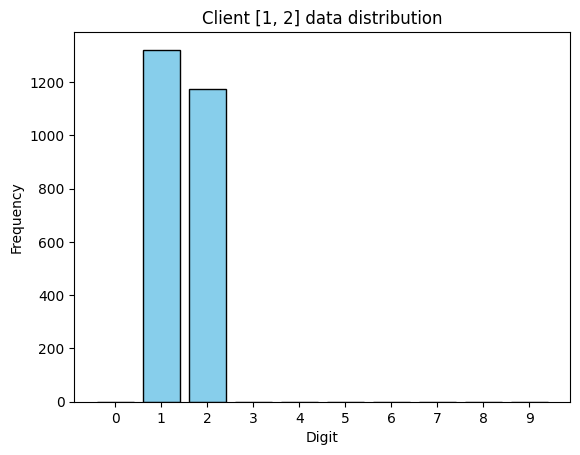

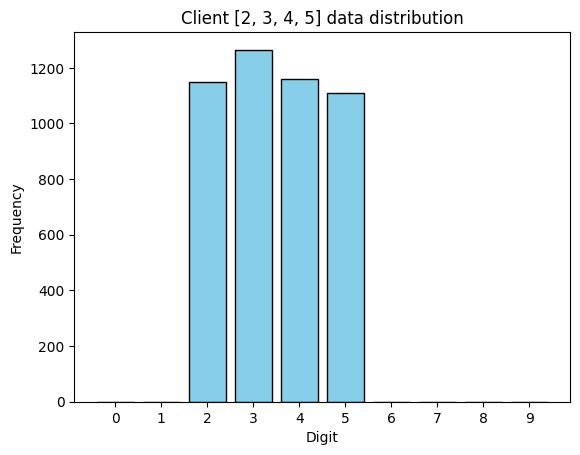

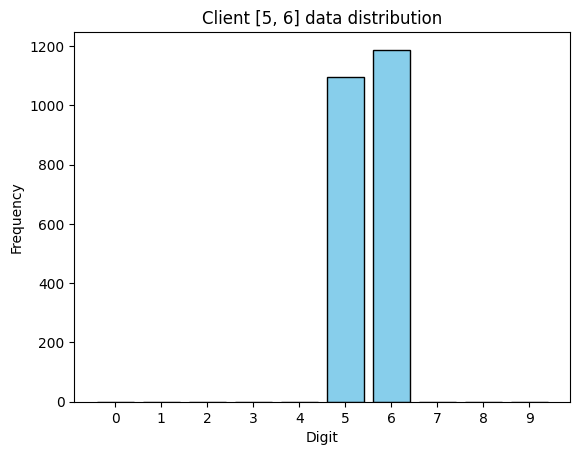

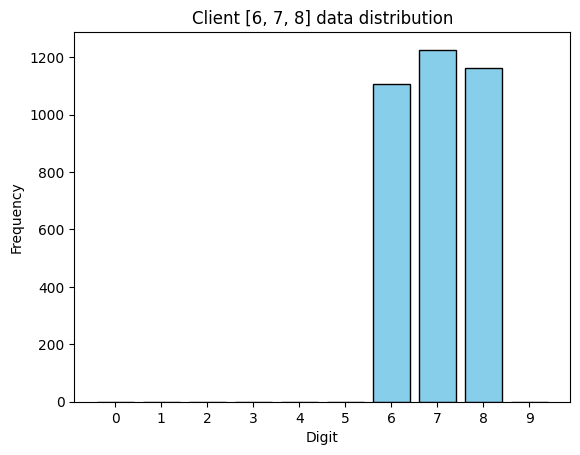

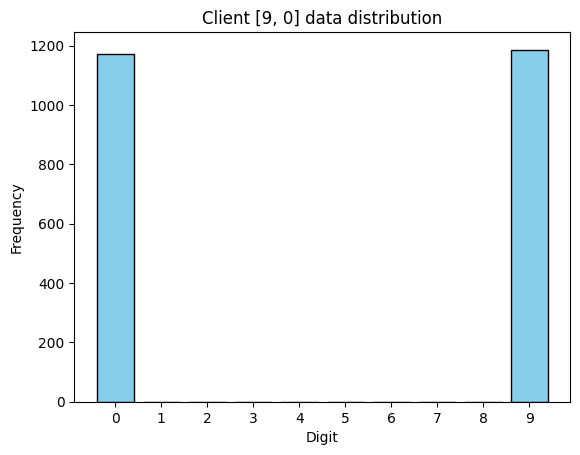

In [5]:
for conf, dataset in zip(clients_data_conf, train_sets):
    plot_label_histogram(dataset, f"Client {conf} data distribution")

Combining all 5 datasets for centralized training experiment

In [6]:
combined_train_set = list(itertools.chain(*train_sets))
np.random.shuffle(combined_train_set)

In [7]:
combined_train_set[0][1]

6

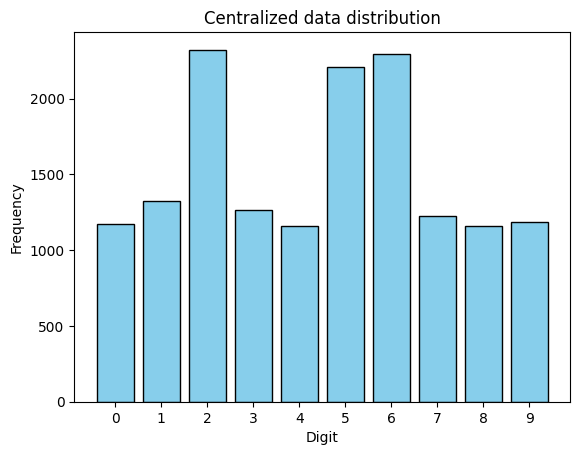

In [8]:
plot_label_histogram(combined_train_set, title="Centralized data distribution")

In [9]:
len(combined_train_set)

15314

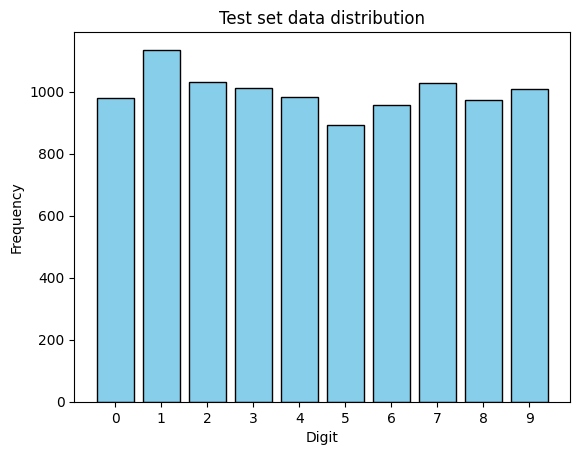

In [10]:
plot_label_histogram(testset, "Test set data distribution")

# Centralized model training

### Defining ML model
- Simple MLP with 4 hiddent layers (512, 256, 128, 64)
- Input layer with input shape (32, 32)
- Output layer with 10 neurons, for 10 classes

In [11]:
model = build_model()
history = train_model(model, combined_train_set, num_epochs=50)
evaluate_model(model, testset)

(0.15448226034641266, 0.9562000036239624)

### Model Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


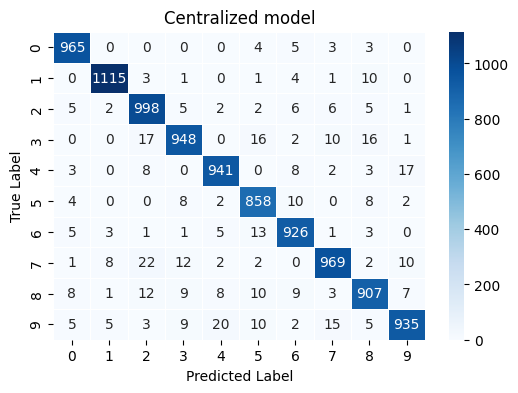

In [12]:
cm = compute_confusion_matrix(model, testset)
plot_confusion_matrix(cm, f"Centralized model")

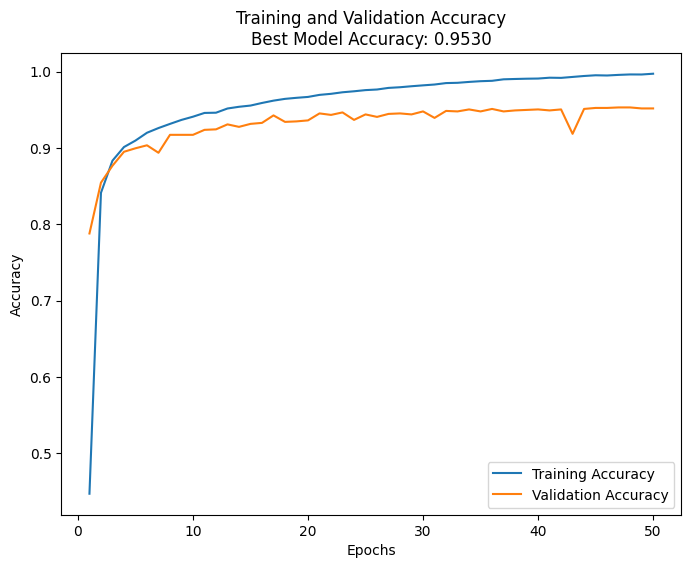

In [13]:
plot_learning_curves(history)

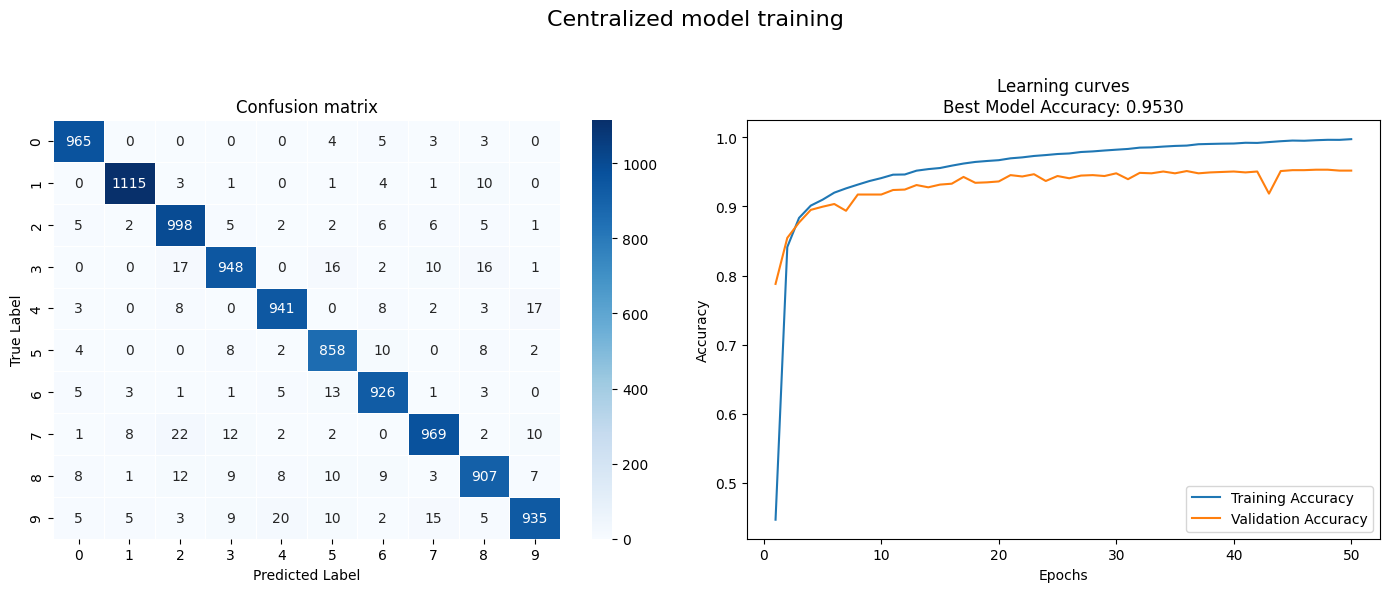

In [14]:
plot_combined(cm, history, "Confusion matrix", "Centralized model training")

## Treaning 5 individual models
- Let`s assume that data each client has are private
- So each client train his own model

(7.9149322509765625, 0.2152000069618225)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


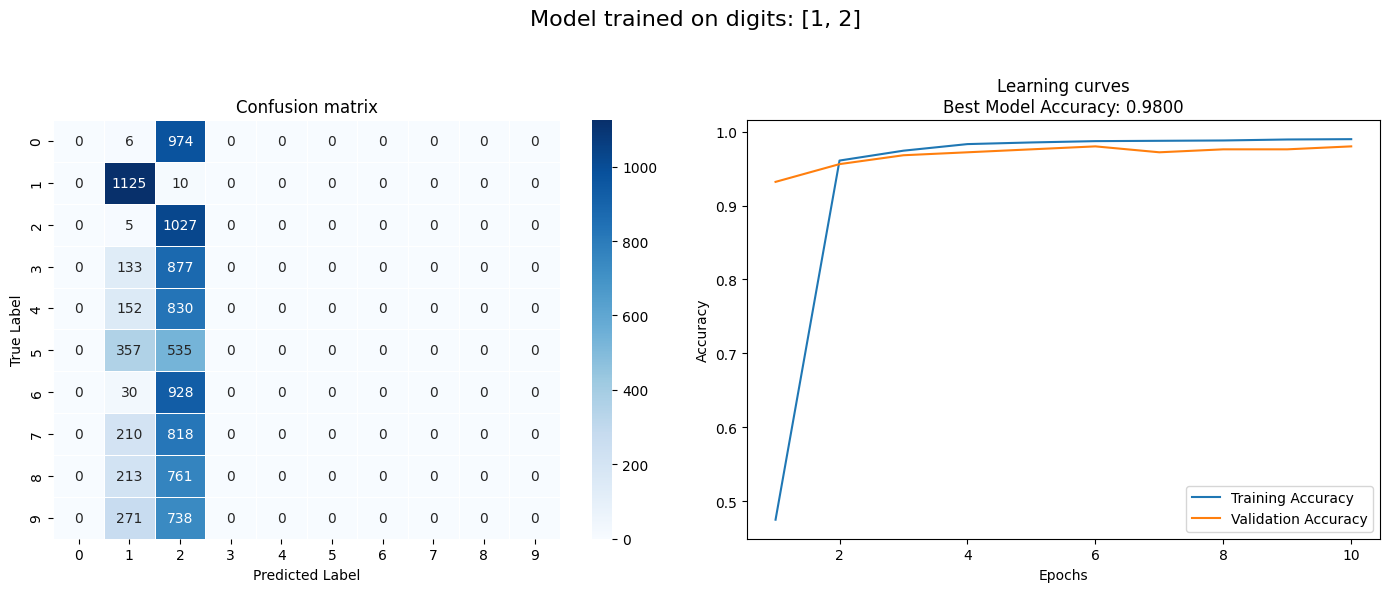

(6.642762660980225, 0.3718000054359436)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


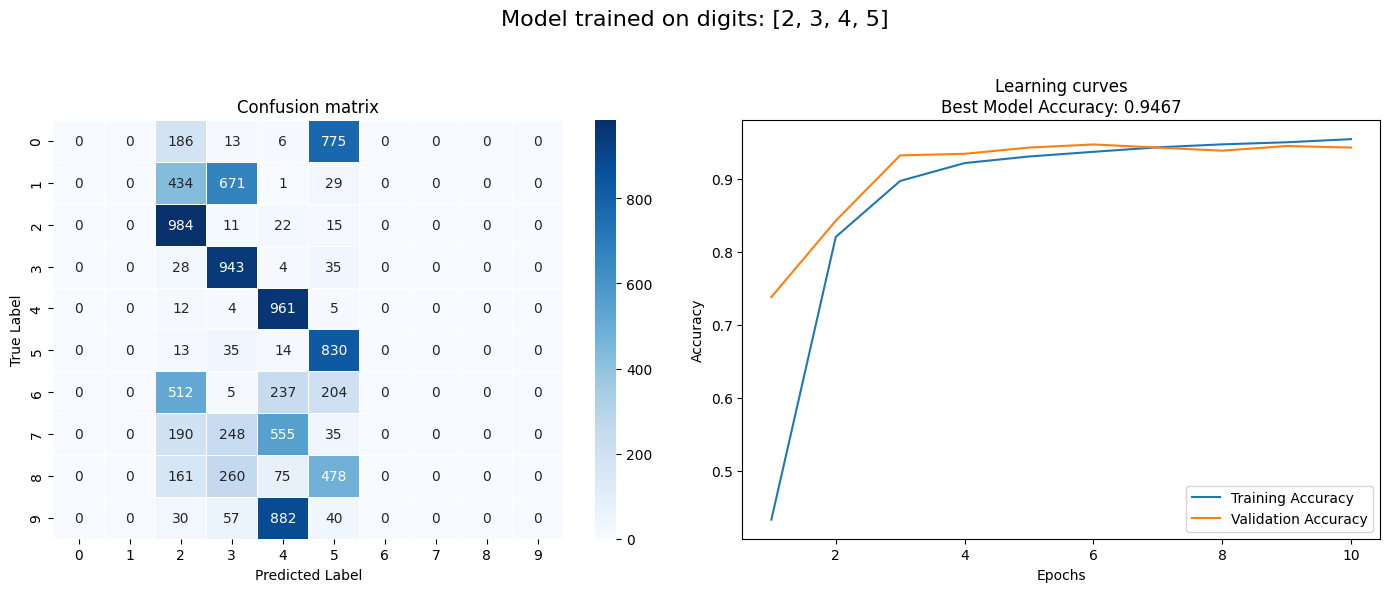

(7.964219570159912, 0.18039999902248383)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


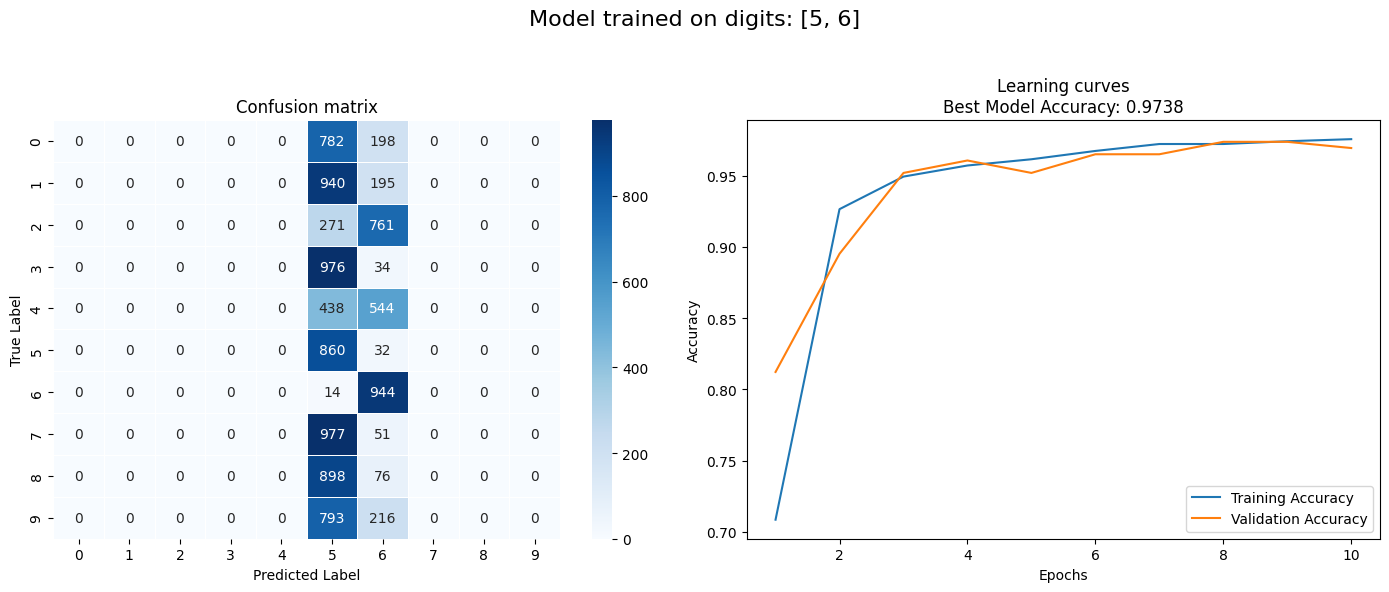

(6.988943099975586, 0.28619998693466187)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step


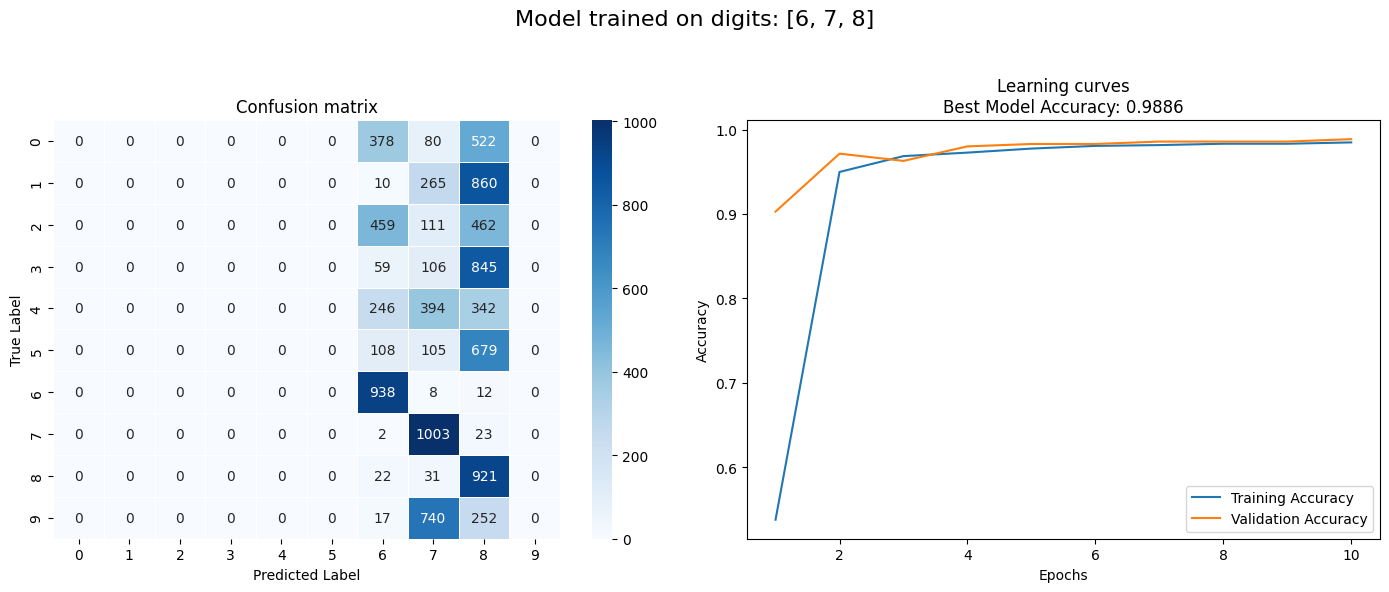

(6.839333534240723, 0.19750000536441803)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


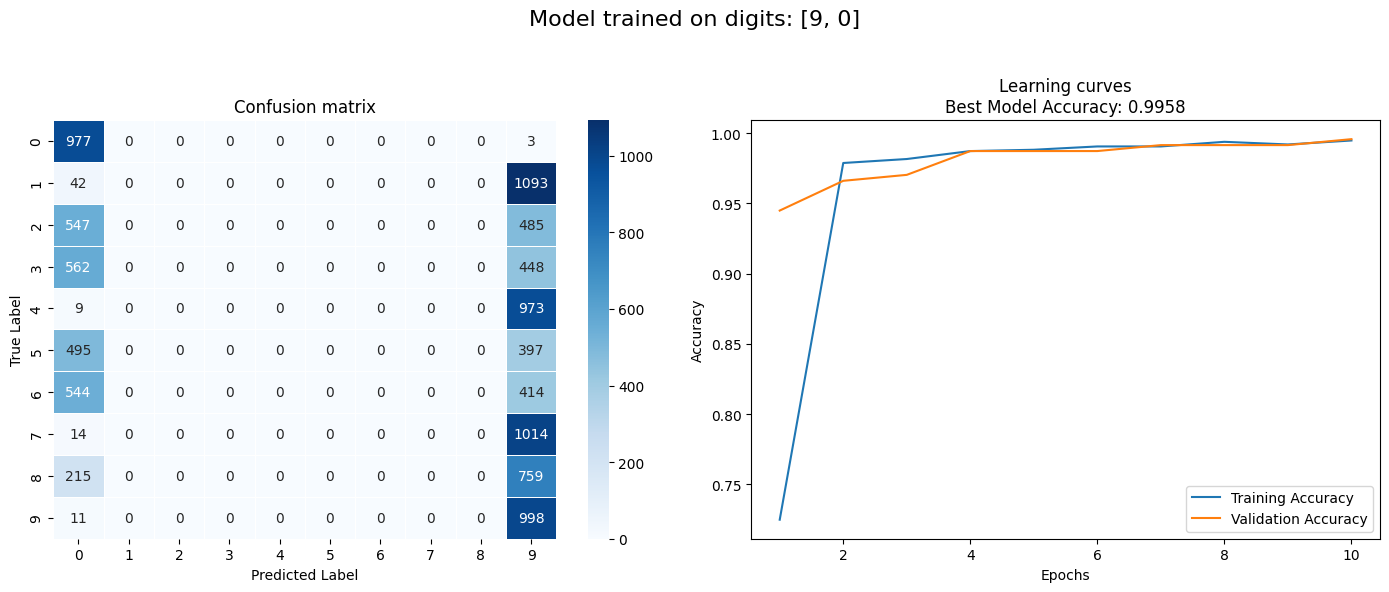

In [15]:
for digits, dataset in zip(clients_data_conf, train_sets):
    model = build_model()
    history = train_model(model, dataset)
    print(evaluate_model(model, testset))
    cm = compute_confusion_matrix(model, testset)
    plot_combined(cm, history, "Confusion matrix", f"Model trained on digits: {digits}")

# Federated model training

### Defining client app

In [16]:
class FlowerClient(NumPyClient):
    def __init__(self, model, trainset, testset):
        self.model = model
        self.trainset = trainset
        self.testset = testset

    # Train the model
    def fit(self, parameters, config):
        set_weights(self.model, parameters)
        train_model(self.model, self.trainset)
        # Evaluate on training data to calculate accuracy
        _, accuracy = evaluate_model(self.model, self.trainset)
        return get_weights(self.model), len(self.trainset), {"accuracy": accuracy}

    # Test the model
    def evaluate(self, parameters: List[np.ndarray], config: Dict[str, float]):
        set_weights(self.model, parameters)
        loss, accuracy = evaluate_model(self.model, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

In [17]:
def client_fn(context: Context) -> Client:
    model = build_model()
    partition_id = int(context.node_config["partition-id"])
    client_train = train_sets[int(partition_id)]
    client_test = testset
    return FlowerClient(model, client_train, client_test).to_client()

In [18]:
client = ClientApp(client_fn)

### Defining server app

In [19]:
global_model_test_acc = []
params = None

def evaluate(server_round, parameters, config):
    model = build_model()
    set_weights(model, parameters)

    _, accuracy = evaluate_model(model, testset)
    log(INFO, "test accuracy on all digits: %.4f", accuracy)
    
    global_model_test_acc.append(accuracy)
    params = parameters.copy()
    
    for digits, client_data in zip(clients_data_conf, train_sets):
        _, accuracy = evaluate_model(model, client_data)
        #log(INFO, f"accuracy on clinet's {digits} data: {round(accuracy, 4)}")

    if server_round%50 == 0:
        cm = compute_confusion_matrix(model, testset)
        plot_confusion_matrix(cm, f"Global Model on round: {server_round}")

Defining FedAvg strategy

In [20]:
# Strategy: Federated Average 'FedAvg'.
model = build_model()
params = ndarrays_to_parameters(get_weights(model))

In [21]:
def server_fn(context: Context):
    strategy = FedAvg(
        fraction_fit=0.8,
        fraction_evaluate=0.6,
        initial_parameters=params,
        evaluate_fn=evaluate,
        min_fit_clients=4,
        min_evaluate_clients=1,
        min_available_clients=4,
        evaluate_metrics_aggregation_fn=weighted_average,
        fit_metrics_aggregation_fn=weighted_average
    )
    config=ServerConfig(num_rounds=250)
    return ServerAppComponents(
        strategy=strategy,
        config=config,
    )

server = ServerApp(server_fn=server_fn)

### Federated simulation

INFO :      Starting Flower ServerApp, config: num_rounds=250, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      test accuracy on all digits: 0.1264


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


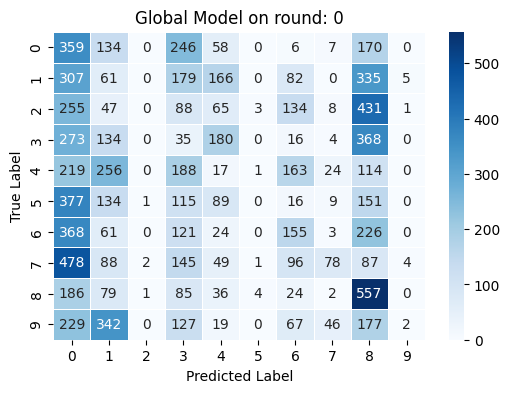

INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.2230
INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.2745
INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.3628
INFO :      configure_evaluate: strategy sampled 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


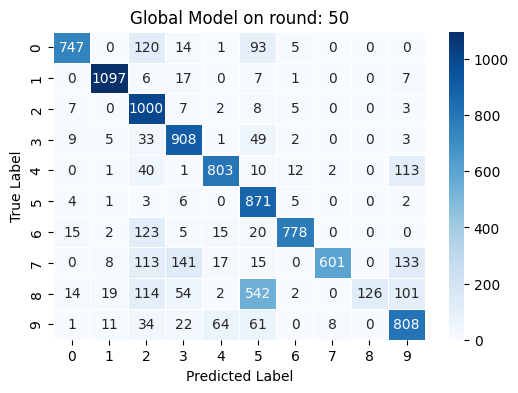

INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.8385
INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.7739
INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :    

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


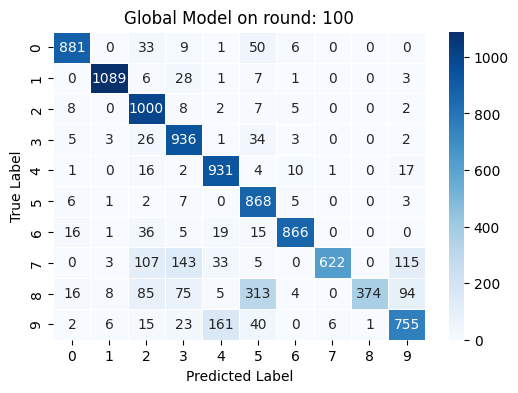

INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 101]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.9106
INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 102]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.8673
INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 103]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO : 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


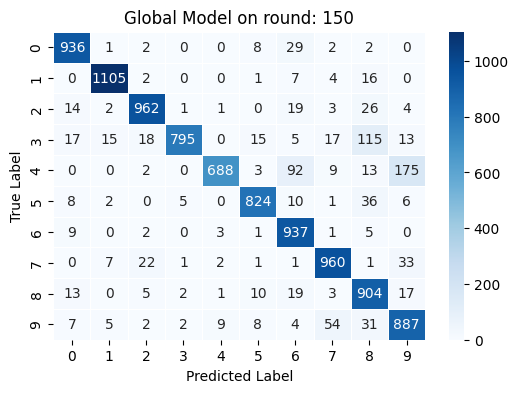

INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 151]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.8498
INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 152]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.8687
INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 153]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO : 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


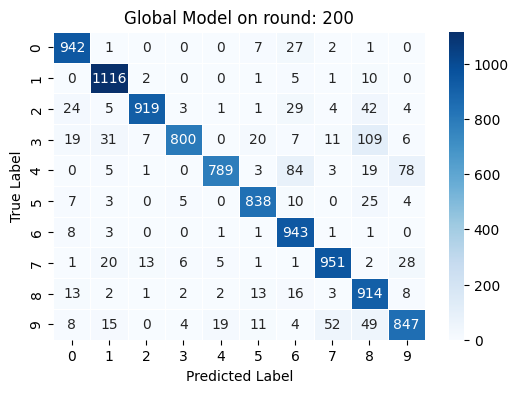

INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 201]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.9254
INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 202]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      test accuracy on all digits: 0.9135
INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 203]
INFO :      configure_fit: strategy sampled 4 clients (out of 5)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO : 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


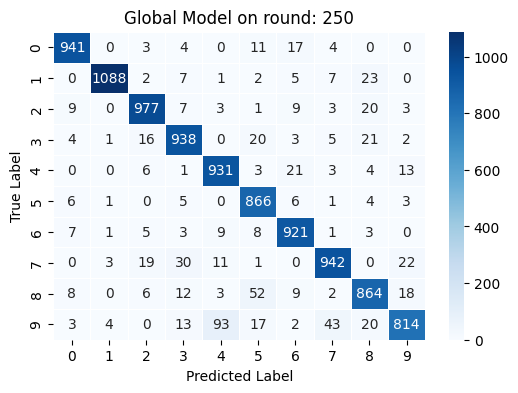

INFO :      configure_evaluate: strategy sampled 3 clients (out of 5)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 250 round(s) in 2544.95s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.7502028942108154
INFO :      		round 2: 3.203792095184326
INFO :      		round 3: 1.9319603443145752
INFO :      		round 4: 2.445397138595581
INFO :      		round 5: 1.4393703937530518
INFO :      		round 6: 1.327978253364563
INFO :      		round 7: 1.5063689947128296
INFO :      		round 8: 1.6750705242156982
INFO :      		round 9: 1.1060776710510254
INFO :      		round 10: 1.4845834970474243
INFO :      		round 11: 1.0517988204956055
INFO :      		round 12: 1.5596421957015991
INFO :      		round 13: 0.7577078938484192
INFO :      		round 14: 0.7760917544364929
INFO :      		round 15: 1.2633470296859741
INFO :      		round 16: 1.228177547454834
INFO :      		round 17: 1.3848339319229126
INFO :      		round

In [22]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=len(clients_data_conf),
    backend_config=backend_setup,
)

In [23]:
global_model_test_acc

[0.12639999389648438,
 0.22300000488758087,
 0.2745000123977661,
 0.3628000020980835,
 0.3637000024318695,
 0.4456999897956848,
 0.5468000173568726,
 0.5422999858856201,
 0.5019999742507935,
 0.6486999988555908,
 0.5892999768257141,
 0.6003999710083008,
 0.5184999704360962,
 0.7371000051498413,
 0.739300012588501,
 0.6510999798774719,
 0.6212000250816345,
 0.609499990940094,
 0.7427999973297119,
 0.6977999806404114,
 0.6801999807357788,
 0.7893999814987183,
 0.743399977684021,
 0.694599986076355,
 0.8015999794006348,
 0.7218999862670898,
 0.7882999777793884,
 0.7709000110626221,
 0.7239999771118164,
 0.7975999712944031,
 0.8339999914169312,
 0.744700014591217,
 0.7509999871253967,
 0.8233000040054321,
 0.8406000137329102,
 0.8540999889373779,
 0.7249000072479248,
 0.8140000104904175,
 0.7437999844551086,
 0.7168999910354614,
 0.7993999719619751,
 0.8356000185012817,
 0.8569999933242798,
 0.8101999759674072,
 0.7713000178337097,
 0.801800012588501,
 0.7699999809265137,
 0.76330000162124

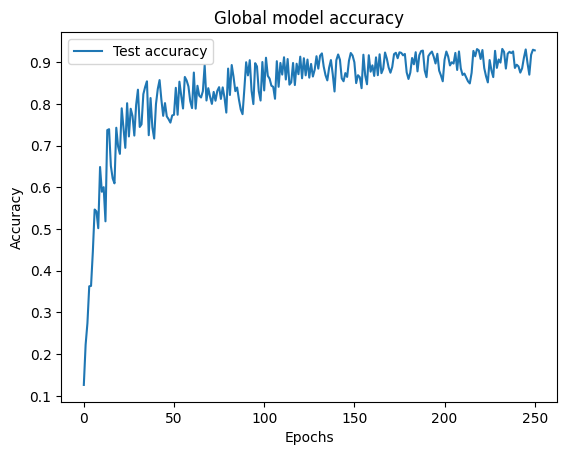

In [24]:
plt.title("Global model accuracy")
plt.plot(global_model_test_acc, label="Test accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()